***
# Machine Learning Model: NCAA Men's March Madness

Each March, the NCAA Men's Basketball Tournament presents a uniquely complex modeling challenge: a single-elimination bracket format where team strength, matchup effects, conference dynamics, and randomness all converge. From a machine learning perspective, this is a high-variance, small-sample classification problem with deeply imbalanced priors and sparse head-to-head overlap — exactly the kind of domain where thoughtful feature engineering can meaningfully outperform brute-force modeling.

To that end, we've built a robust tournament-ready dataset from the ground up — integrating raw results, team metadata, and historical regular season play. Beyond box score statistics, we’ve derived a suite of advanced features: win/loss splits, opponent-adjusted metrics, and differential deltas — all computed at the team-season level and carried forward into each tournament matchup.

The goal now is to apply supervised learning techniques to model tournament outcomes through the following steps:

- Model Preparation  
- Baseline Model Predictions  
- Model Selection(s)
- Model Iterations:  
    - Logistic Regression  
    - XGBoost
- Model Evaluation
***

## Imports & Global Settings

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, log_loss, ConfusionMatrixDisplay, RocCurveDisplay, accuracy_score, recall_score
from sklearn.metrics import precision_score, f1_score, classification_report, precision_recall_curve, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

from xgboost import XGBClassifier
from Utils import *

# Ignore futurewarnings
import warnings
warnings.filterwarnings('ignore')

In [44]:
pd.set_option('display.max_columns', None)
jimmer = 32 # Jimmer Fredette jersey number for randomizaion
duke = 1181 # TeamID for Duke to use for reference / debugging

***
## Model Preparation
***

In [45]:
tournament_df = pd.read_csv('./Data/Live/TournamentMatchupData.csv', dtype={
    'TeamID': str,
    'OppTeamID': str
})

In [46]:
display(tournament_df.tail())

,Season,DayNum,TeamID,OppTeamID,TeamScore,OppScore,GameResult,Win,TeamName,OppTeamName,KenPomRank,OppKenPomRank,ConfAbbrev,Description,ConfAbbrev_Opp,Description_Opp,NumOT,TotalGames,TotalWins,TotalLosses,WinningPercentage,Score_PerGame,OppScore_PerGame,NumOT_PerGame,FGM_PerGame,FGA_PerGame,FGM3_PerGame,FGA3_PerGame,FTM_PerGame,FTA_PerGame,OR_PerGame,DR_PerGame,Ast_PerGame,TO_PerGame,Stl_PerGame,Blk_PerGame,PF_PerGame,OppFGM_PerGame,OppFGA_PerGame,OppFGM3_PerGame,OppFGA3_PerGame,OppFTM_PerGame,OppFTA_PerGame,OppOR_PerGame,OppDR_PerGame,OppAst_PerGame,OppTO_PerGame,OppStl_PerGame,OppBlk_PerGame,OppPF_PerGame,Win_PerGame,FG_Percentage_PerGame,FG3_Percentage_PerGame,FT_Percentage_PerGame,Ast_TO_Ratio_PerGame,OppFG_Percentage_PerGame,OppFG3_Percentage_PerGame,OppFT_Percentage_PerGame,OppAst_TO_Ratio_PerGame,Poss_PerGame,OppPoss_PerGame,OffEff_PerGame,DefEff_PerGame,OppOffEff_PerGame,OppDefEff_PerGame,Score_Diff_PerGame,FGM_Diff_PerGame,FGA_Diff_PerGame,FGM3_Diff_PerGame,FGA3_Diff_PerGame,FTM_Diff_PerGame,FTA_Diff_PerGame,OR_Diff_PerGame,DR_Diff_PerGame,Ast_Diff_PerGame,TO_Diff_PerGame,Stl_Diff_PerGame,Blk_Diff_PerGame,PF_Diff_PerGame,Poss_Diff_PerGame,OffEff_Diff_PerGame,DefEff_Diff_PerGame,Score_Diff_Pct_PerGame,FGM_Diff_Pct_PerGame,FGA_Diff_Pct_PerGame,FGM3_Diff_Pct_PerGame,FGA3_Diff_Pct_PerGame,FTM_Diff_Pct_PerGame,FTA_Diff_Pct_PerGame,OR_Diff_Pct_PerGame,DR_Diff_Pct_PerGame,Ast_Diff_Pct_PerGame,TO_Diff_Pct_PerGame,Stl_Diff_Pct_PerGame,Blk_Diff_Pct_PerGame,PF_Diff_Pct_PerGame,Poss_Diff_Pct_PerGame,OffEff_Diff_Pct_PerGame,DefEff_Diff_Pct_PerGame,Score_Diff_Opp_PerGame,FGM_Diff_Opp_PerGame,FGA_Diff_Opp_PerGame,FGM3_Diff_Opp_PerGame,FGA3_Diff_Opp_PerGame,FTM_Diff_Opp_PerGame,FTA_Diff_Opp_PerGame,OR_Diff_Opp_PerGame,DR_Diff_Opp_PerGame,Ast_Diff_Opp_PerGame,TO_Diff_Opp_PerGame,Stl_Diff_Opp_PerGame,Blk_Diff_Opp_PerGame,PF_Diff_Opp_PerGame,Poss_Diff_Opp_PerGame,OffEff_Diff_Opp_PerGame,DefEff_Diff_Opp_PerGame,Score_Diff_Pct_Opp_PerGame,FGM_Diff_Pct_Opp_PerGame,FGA_Diff_Pct_Opp_PerGame,FGM3_Diff_Pct_Opp_PerGame,FGA3_Diff_Pct_Opp_PerGame,FTM_Diff_Pct_Opp_PerGame,FTA_Diff_Pct_Opp_PerGame,OR_Diff_Pct_Opp_PerGame,DR_Diff_Pct_Opp_PerGame,Ast_Diff_Pct_Opp_PerGame,TO_Diff_Pct_Opp_PerGame,Stl_Diff_Pct_Opp_PerGame,Blk_Diff_Pct_Opp_PerGame,PF_Diff_Pct_Opp_PerGame,Poss_Diff_Pct_Opp_PerGame,OffEff_Diff_Pct_Opp_PerGame,DefEff_Diff_Pct_Opp_PerGame,KenPomRank_PerGame,OppKenPomRank_PerGame,KenPomDiff_PerGame,OppKenPomDiff_PerGame,Score_PerWin,OppScore_PerWin,NumOT_PerWin,FGM_PerWin,FGA_PerWin,FGM3_PerWin,FGA3_PerWin,FTM_PerWin,FTA_PerWin,OR_PerWin,DR_PerWin,Ast_PerWin,TO_PerWin,Stl_PerWin,Blk_PerWin,PF_PerWin,OppFGM_PerWin,OppFGA_PerWin,OppFGM3_PerWin,OppFGA3_PerWin,OppFTM_PerWin,OppFTA_PerWin,OppOR_PerWin,OppDR_PerWin,OppAst_PerWin,OppTO_PerWin,OppStl_PerWin,OppBlk_PerWin,OppPF_PerWin,Win_PerWin,FG_Percentage_PerWin,FG3_Percentage_PerWin,FT_Percentage_PerWin,Ast_TO_Ratio_PerWin,OppFG_Percentage_PerWin,OppFG3_Percentage_PerWin,OppFT_Percentage_PerWin,OppAst_TO_Ratio_PerWin,Poss_PerWin,OppPoss_PerWin,OffEff_PerWin,DefEff_PerWin,OppOffEff_PerWin,OppDefEff_PerWin,Score_Diff_PerWin,FGM_Diff_PerWin,FGA_Diff_PerWin,FGM3_Diff_PerWin,FGA3_Diff_PerWin,FTM_Diff_PerWin,FTA_Diff_PerWin,OR_Diff_PerWin,DR_Diff_PerWin,Ast_Diff_PerWin,TO_Diff_PerWin,Stl_Diff_PerWin,Blk_Diff_PerWin,PF_Diff_PerWin,Poss_Diff_PerWin,OffEff_Diff_PerWin,DefEff_Diff_PerWin,Score_Diff_Pct_PerWin,FGM_Diff_Pct_PerWin,FGA_Diff_Pct_PerWin,FGM3_Diff_Pct_PerWin,FGA3_Diff_Pct_PerWin,FTM_Diff_Pct_PerWin,FTA_Diff_Pct_PerWin,OR_Diff_Pct_PerWin,DR_Diff_Pct_PerWin,Ast_Diff_Pct_PerWin,TO_Diff_Pct_PerWin,Stl_Diff_Pct_PerWin,Blk_Diff_Pct_PerWin,PF_Diff_Pct_PerWin,Poss_Diff_Pct_PerWin,OffEff_Diff_Pct_PerWin,DefEff_Diff_Pct_PerWin,Score_Diff_Opp_PerWin,FGM_Diff_Opp_PerWin,FGA_Diff_Opp_PerWin,FGM3_Diff_Opp_PerWin,FGA3_Diff_Opp_PerWin,FTM_Diff_Opp_PerWin,FTA_Diff_Opp_PerWin,OR_Diff_Opp_PerWin,DR_Diff_Opp_PerWin,Ast_Diff_Opp_PerWin,TO_Diff_Opp_PerWin,Stl_Diff_Opp_PerWin,Blk_Diff_Opp_PerWin,PF_Diff_Opp_PerWin,Pos

***
## Categorical Variables
***

In [47]:
object_cols = tournament_df.select_dtypes(include=['object']).columns.tolist()
cat_cols = [col for col in object_cols if not col.endswith('_Opp')]
tournament_df[cat_cols].nunique()

TeamID         268
OppTeamID      268
GameResult       2
TeamName       268
OppTeamName    268
ConfAbbrev      34
Description     34
Seed            94
Region           4
dtype: int64

Let's dive a little deeper into the conference breakdowns before encoding those features for modeling.

In [48]:
# No need to include Opp details given each game has two rows for each team
conf_df = tournament_df[['Season', 'TeamID', 'TeamName','ConfAbbrev', 'GameResult']]
conf_df

,Season,TeamID,TeamName,ConfAbbrev,GameResult
0,2003,1411,TX Southern,SWAC,L
1,2003,1421,UNC Asheville,BIG_SOUTH,W
2,2003,1112,Arizona,PAC_TEN,W
3,2003,1113,Arizona St,PAC_TEN,W
4,2003,1140,BYU,MWC,L
...,...,...,...,...,...
2759,2024,1163,Connecticut,BIG_EAST,W
2760,2024,1301,NC State,ACC,L
2761,2024,1345,Purdue,BIG_TEN,W
2762,2024,1163,Connecticut,BIG_EAST,W


In [49]:
# Get the number of teams sent to tournament per season by conference
teams_per_conf_season = conf_df.groupby(["Season", "ConfAbbrev"])["TeamID"].nunique().reset_index(name="NumTeams")

# Get the avg. number of teams sent to tournament by conference
conf_avg_teams = teams_per_conf_season.groupby("ConfAbbrev")["NumTeams"].mean().sort_values(ascending=True)
overall_avg = conf_avg_teams.values.mean()

In [50]:
conf_avg_teams.sort_values(ascending=False).head(10)

ConfAbbrev
BIG_TEN       6.285714
BIG_EAST      6.238095
BIG_TWELVE    6.047619
ACC           5.809524
SEC           5.333333
PAC_TEN       4.444444
PAC_TWELVE    4.166667
A_TEN         2.809524
MWC           2.809524
AAC           2.700000
Name: NumTeams, dtype: float64

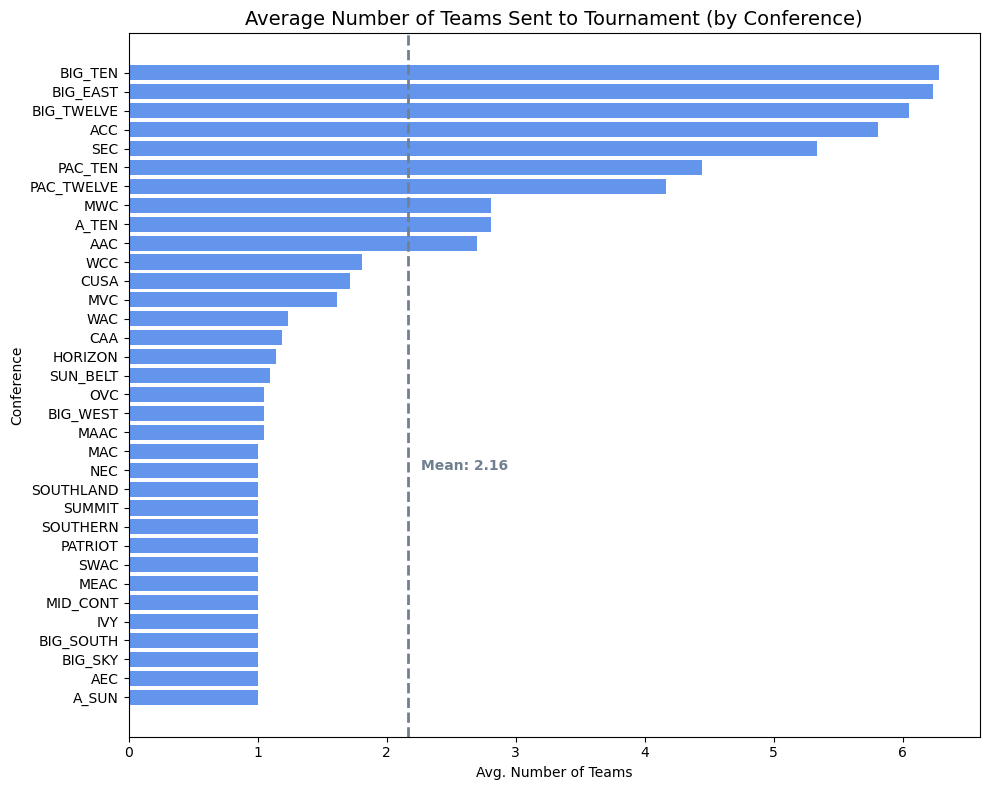

In [51]:
# Plot
fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(conf_avg_teams.index, conf_avg_teams.values, color="cornflowerblue")

# Format
ax.set_title("Average Number of Teams Sent to Tournament (by Conference)", fontsize=14)
ax.set_xlabel("Avg. Number of Teams")
ax.set_ylabel("Conference")

# Plot mean and format data label
ax.axvline(conf_avg_teams.values.mean(), color='slategrey', linestyle='--', linewidth=2)
ax.text(overall_avg + 0.1, 12, f"Mean: {overall_avg:.2f}",
        color='slategrey', fontsize=10, fontweight='bold')

# Step 5: Display
plt.tight_layout()
plt.show()


Given the structure of automatic bids and at-large selections, larger `"Power Conferences"` often send significantly more teams to the NCAA tournament compared to mid-major conferences, which typically send just one team — their conference champion.

These conferences differ greatly in talent level and strength of schedule, both of which are key factors in advanced metrics like NET Rating and Quadrant Wins. As a result, comparing two teams with identical 25–5 records and similar basic stats (PPG, APG, OppFG%, etc.) can be misleading if one plays in the `Big_Ten` and the other in the `A_SUN`. On paper their stats may look alike, but in reality, they’re playing in very different competitive environments (comparing apples to oranges).

In [52]:
# Filter to only rows where NumTeams > n to declutter plot
n = 0
filtered = teams_per_conf_season[teams_per_conf_season["NumTeams"] > 1]

# Get unique seasons (Note: no 2020 due to COVID)
seasons = sorted(filtered["Season"].unique(), reverse=True)

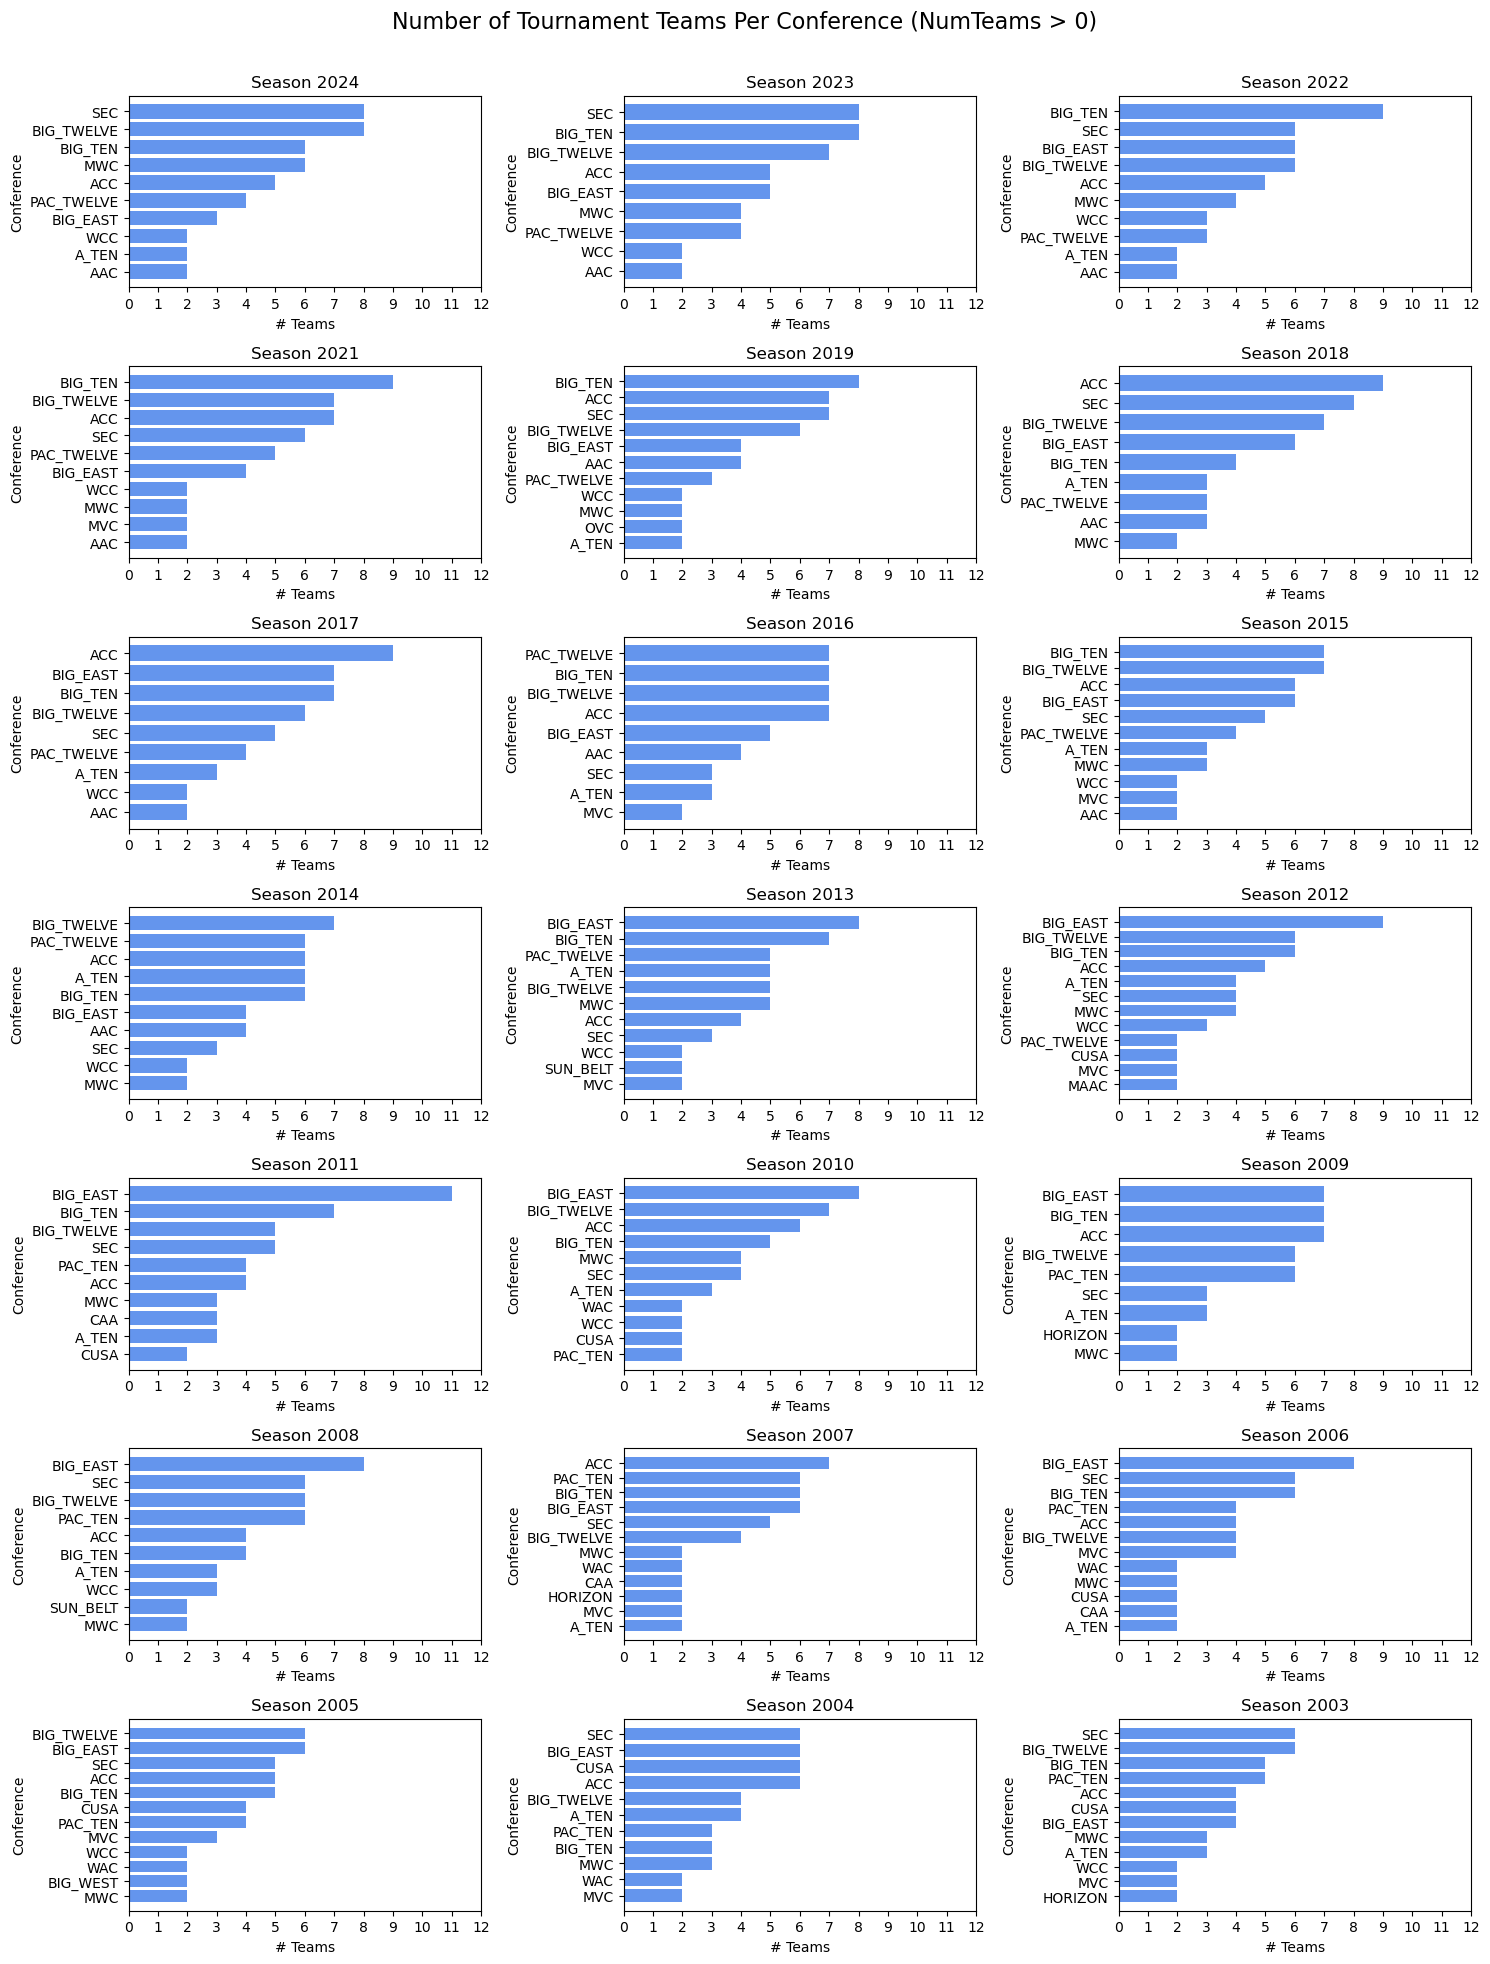

In [53]:
max_teams = filtered["NumTeams"].max()

# Create subplots
rows, cols = 7, 3
fig, axes = plt.subplots(rows, cols, figsize=(15, 20))
axes = axes.flatten()

# Loop through each season and create a horizontal bar chart
for i, season in enumerate(seasons):
    ax = axes[i]
    season_data = filtered[filtered["Season"] == season].sort_values("NumTeams", ascending=True)
    ax.barh(season_data["ConfAbbrev"], season_data["NumTeams"], color="cornflowerblue")

    # Formatting
    ax.set_title(f"Season {season}")
    ax.set_xlabel("# Teams")
    ax.set_ylabel("Conference")
    ax.set_xlim(0, max_teams + 1)
    ax.set_xticks(range(0, max_teams + 2))


plt.suptitle(f"Number of Tournament Teams Per Conference (NumTeams > {n})\n\n", fontsize=16)
plt.tight_layout()
plt.show()

Although there has been some mix-shift among the top conferences over the years, the traditional `"Power Conferences"` continue to anchor the college basketball landscape. These leagues consistently send multiple teams to the NCAA tournament, reinforcing their dominance and depth of competition.

While individual conference rankings may fluctuate season to season, the presence of conferences like the `Big_Ten`, `Big_12`, and `SEC` at the top remains a constant — a testament to their sustained strength and influence in shaping the tournament field.

Rather than encode each conference individually, `"PowerConference"` feature — a binary indicator that flags whether a team belongs to a traditional power conference. This simplifies the representation while preserving a meaningful distinction in program strength and competition level.

Though the landscape of what qualifies as a power conference can be somewhat subjective, the data offers a clear breakpoint. On average, the `PAC_TWELVE` sends approximately 4.17 teams per season, while the next closest conference, `A_TEN`, averages just 2.81 — a 31% relative drop. This represents the largest gap in average bids between any two adjacent conferences in the ranked distribution.

From a statistical standpoint, this "elbow" in the distribution suggests a natural inflection point. Conferences above this threshold consistently field multiple at-large teams and operate with materially stronger competitive profiles. Therefore, we draw the line just below PAC_TWELVE, grouping the top seven conferences (`Big_Ten`, `Big_12`, `SEC`, `ACC`, `Big_East`, `Pac_Ten`, `Pac_Twelve`) into the `"PowerConference"` category.

In [54]:
power_conferences = ['Big_Ten', 'Big_12', 'SEC', 'ACC', 'Big_East', 'Pac_Ten', 'Pac_Twelve']

# Tag conferences a power conferences
tournament_df["PowerConference"] = tournament_df["ConfAbbrev"].isin(power_conferences).astype(int)
tournament_df["Opp_PowerConference"] = tournament_df["ConfAbbrev_Opp"].isin(power_conferences).astype(int)

# Drop conferences and conference descriptions
tournament_df = tournament_df.drop(columns=['ConfAbbrev', 'Description', 'ConfAbbrev_Opp', 'Description_Opp'])
tournament_df

Season  DayNum TeamID OppTeamID  TeamScore  OppScore GameResult  Win  \
0       2003     134   1411      1421         84        92          L    0   
1       2003     134   1421      1411         92        84          W    1   
2       2003     136   1112      1436         80        51          W    1   
3       2003     136   1113      1272         84        71          W    1   
4       2003     136   1140      1163         53        58          L    0   
...      ...     ...    ...       ...        ...       ...        ...  ...   
2759    2024     152   1163      1104         86        72          W    1   
2760    2024     152   1301      1345         50        63          L    0   
2761    2024     152   1345      1301         63        50          W    1   
2762    2024     154   1163      1345         75        60          W    1   
2763    2024     154   1345      1163         60        75          L    0   

           TeamName    OppTeamName  KenPomRank  OppKenPomRank  NumOT  \
0       TX Southern  UNC Asheville         268            273      1   
1     UNC Asheville    TX Southern         273            268      1   
2           Arizona        Vermont           3            144      0   
3        Arizona St        Memphis          32             20      0   
4               BYU    Connecticut          26             23      0   
...             ...            ...         ...            ...    ...   
2759    Connecticut        Alabama           1             13      0   
2760       NC State         Purdue          58              3      0   
2761         Purdue       NC State           3             58      0   
2762    Connecticut         Purdue           1              3      0   
2763         Purdue    Connecticut           3              1      0   

      TotalGames  TotalWins  TotalLosses  WinningPercentage  Score_PerGame  \
0             30         18           12           0.600000      72.800000   
1             29         13           16           0.448276      71.206897   
2             28         25            3           0.892857      85.214286   
3             29         18           11           0.620690      75.965517   
4             31         23            8           0.741935      72.451613   
...          ...        ...          ...                ...            ...   
2759          34         31            3           0.911765      81.470588   
2760          36         22           14           0.611111      76.361111   
2761          33         29            4           0.878788      83.393939   
2762          34         31            3           0.911765      81.470588   
2763          33         29            4           0.878788      83.393939   

      OppScore_PerGame  NumOT_PerGame  FGM_PerGame  FGA_PerGame  FGM3_PerGame  \
0            70.833333       0.033333    24.733333    55.266667      5.933333   
1            78.448276       0.172414    24.379310    56.793103      6.482759   
2            70.250000       0.071429    30.321429    65.714286      7.035714   
3            69.172414       0.068966    27.206897    56.896552      4.000000   
4            63.677419       0.032258    24.032258    51.258065      6.193548   
...                ...            ...          ...          ...           ...   
2759         64.411765       0.000000    29.088235    58.647059      8.794118   
2760         72.694444       0.083333    27.388889    60.972222      7.055556   
2761         70.151515       0.090909    28.515152    58.393939      8.333333   
2762         64.411765       0.000000    29.088235    58.647059      8.794118   
2763         70.151515       0.090909    28.515152    58.393939      8.333333   

      FGA3_PerGame  FTM_PerGame  FTA_PerGame  OR_PerGame  DR_PerGame  \
0        18.500000    17.400000    28.066667   13.166667   24.800000   
1        18.000000    15.965517    20.931034   12.275862   23.172414   
2        20.071429    17.535714    25.000000   15.178571   27.642857   
3     

In [55]:
object_cols = tournament_df.select_dtypes(include=['object']).columns.tolist()
tournament_df[object_cols]

,TeamID,OppTeamID,GameResult,TeamName,OppTeamName,Seed,Region,Seed_Opp,Region_Opp
0,1411,1421,L,TX Southern,UNC Asheville,X16a,X,X16b,X
1,1421,1411,W,UNC Asheville,TX Southern,X16b,X,X16a,X
2,1112,1436,W,Arizona,Vermont,Z01,Z,Z16,Z
3,1113,1272,W,Arizona St,Memphis,Z10,Z,Z07,Z
4,1140,1163,L,BYU,Connecticut,X12,X,X05,X
...,...,...,...,...,...,...,...,...,...
2759,1163,1104,W,Connecticut,Alabama,W01,W,X04,X
2760,1301,1345,L,NC State,Purdue,Z11,Z,Y01,Y
2761,1345,1301,W,Purdue,NC State,Y01,Y,Z11,Z
2762,1163,1345,W,Connecticut,Purdue,W01,W,Y01,Y


At this stage, we’ll drop the remaining non-numeric columns from the dataset. Identifiers like `TeamName` and `TeamID` don't contain predictive power and introduce unintended noise in the modeling phase. Removing them ensures the model is trained strictly on meaningful, quantitative features.

In [56]:
tournament_df = tournament_df.drop(columns=object_cols)

***
## Baseline Model Predictions
***

Before assessing the performance of any machine learning model, it's critical to establish a strong baseline: a simple, intuitive benchmark that represents what could be reasonably achieved with domain knowledge and a touch of luck.

In the context of the NCAA tournament, seeding reflects the selection committee’s composite view of team strength, informed by record, schedule, and a range of advanced metrics. As such, a natural baseline is to predict that the higher-seeded team will win each game. In the event that two teams share the same seed, final `KenPomRank` will be used as the tie breaker.

This rule-based approach offers more than just a coin flip; it represents a level of predictive accuracy that a well-informed observer might achieve without the help of machine learning. If our model can’t outperform this, we’ve added complexity without value. But if it can, there is a compelling case that the model is capturing signal beyond just chalk.

In [57]:
tournament_df

Season  DayNum  TeamScore  OppScore  Win  KenPomRank  OppKenPomRank  \
0       2003     134         84        92    0         268            273   
1       2003     134         92        84    1         273            268   
2       2003     136         80        51    1           3            144   
3       2003     136         84        71    1          32             20   
4       2003     136         53        58    0          26             23   
...      ...     ...        ...       ...  ...         ...            ...   
2759    2024     152         86        72    1           1             13   
2760    2024     152         50        63    0          58              3   
2761    2024     152         63        50    1           3             58   
2762    2024     154         75        60    1           1              3   
2763    2024     154         60        75    0           3              1   

      NumOT  TotalGames  TotalWins  TotalLosses  WinningPercentage  \
0         1          30         18           12           0.600000   
1         1          29         13           16           0.448276   
2         0          28         25            3           0.892857   
3         0          29         18           11           0.620690   
4         0          31         23            8           0.741935   
...     ...         ...        ...          ...                ...   
2759      0          34         31            3           0.911765   
2760      0          36         22           14           0.611111   
2761      0          33         29            4           0.878788   
2762      0          34         31            3           0.911765   
2763      0          33         29            4           0.878788   

      Score_PerGame  OppScore_PerGame  NumOT_PerGame  FGM_PerGame  \
0         72.800000         70.833333       0.033333    24.733333   
1         71.206897         78.448276       0.172414    24.379310   
2         85.214286         70.250000       0.071429    30.321429   
3         75.965517         69.172414       0.068966    27.206897   
4         72.451613         63.677419       0.032258    24.032258   
...             ...               ...            ...          ...   
2759      81.470588         64.411765       0.000000    29.088235   
2760      76.361111         72.694444       0.083333    27.388889   
2761      83.393939         70.151515       0.090909    28.515152   
2762      81.470588         64.411765       0.000000    29.088235   
2763      83.393939         70.151515       0.090909    28.515152   

      FGA_PerGame  FGM3_PerGame  FGA3_PerGame  FTM_PerGame  FTA_PerGame  \
0       55.266667      5.933333     18.500000    17.400000    28.066667   
1       56.793103      6.482759     18.000000    15.965517    20.931034   
2       65.714286      7.035714     20.071429    17.535714    25.000000   
3       56.896552      4.000000     12.586207    17.551724    26.206897   
4       51.258065      6.193548     16.129032    18.193548    24.161290   
...           ...           ...           ...          ...          ...   
2759    58.647059      8.794118     23.970588    14.500000    19.529412   
2760    60.972222      7.055556     20.388889    14.527778    19.805556   
2761    58.393939      8.333333     20.424242    18.030303    25.000000   
2762    58.647059      8.794118     23.970588    14.500000    19.529412   
2763    58.393939      8.333333     20.424242    18.030303    25.000000   

      OR_PerGame  DR_PerGame  Ast_PerGame  TO_PerGame  Stl_PerGame  \
0      13.166667   24.800000    14.200000   15.233333     6.433333   
1      12.275862   23.172414    13.034483   16.206897     7.068966   
2      15.178571   27.642857    17.642857   14.785714     8.464286   
3      13.689655   23.310345    15.551724   14.000000     5.206897   
4      10.870968   24.419355    13.419355   13.741935     6.935484   
...          ...         ...          ...         ...          ...   
2759   10.088235   2

In [58]:
# Assuming lower seed ("higher ranked") team wins
tournament_df['BaselinePrediction'] = tournament_df['SeedNum'] < tournament_df['SeedNum_Opp']

# In the event two teams are the same Seed, the 'BaselinePrediction' is assigned to the team with lower KenPom ("higher") Rank
tournament_df.loc[tournament_df["SeedNum"] == tournament_df["SeedNum_Opp"], 'BaselinePrediction'] = (
    tournament_df["KenPomRank"] < tournament_df["OppKenPomRank"]
)

# Convert to 0,1s
tournament_df['BaselinePrediction'] = tournament_df['BaselinePrediction'].astype(int)

In [59]:
# Get baseline score and accuracy for each season
baseline_scores = []

for season in tournament_df['Season'].unique():
    pred = tournament_df[tournament_df['Season'] == season]['BaselinePrediction']
    y = tournament_df[tournament_df['Season'] == season]['Win']

    score = accuracy_score(y, pred)
    score_ll = log_loss(y, pred)
    baseline_scores.append(score)

    print(f"Season: {season} | Accuracy {score:0.4f} | Log Loss {score_ll:0.4f}")

print(f"Baseline accuracy {np.mean(baseline_scores):0.4f}")

Season: 2003 | Accuracy 0.6562 | Log Loss 12.3900
Season: 2004 | Accuracy 0.7344 | Log Loss 9.5741
Season: 2005 | Accuracy 0.6875 | Log Loss 11.2636
Season: 2006 | Accuracy 0.6719 | Log Loss 11.8268
Season: 2007 | Accuracy 0.8125 | Log Loss 6.7582
Season: 2008 | Accuracy 0.7812 | Log Loss 7.8845
Season: 2009 | Accuracy 0.7500 | Log Loss 9.0109
Season: 2010 | Accuracy 0.6562 | Log Loss 12.3900
Season: 2011 | Accuracy 0.6866 | Log Loss 11.2973
Season: 2012 | Accuracy 0.7015 | Log Loss 10.7593
Season: 2013 | Accuracy 0.6866 | Log Loss 11.2973
Season: 2014 | Accuracy 0.6716 | Log Loss 11.8352
Season: 2015 | Accuracy 0.7313 | Log Loss 9.6834
Season: 2016 | Accuracy 0.6866 | Log Loss 11.2973
Season: 2017 | Accuracy 0.7313 | Log Loss 9.6834
Season: 2018 | Accuracy 0.6716 | Log Loss 11.8352
Season: 2019 | Accuracy 0.7015 | Log Loss 10.7593
Season: 2021 | Accuracy 0.6818 | Log Loss 11.4684
Season: 2022 | Accuracy 0.6866 | Log Loss 11.2973
Season: 2023 | Accuracy 0.6716 | Log Loss 11.8352
Season

***
### Baseline Accuracy Evaluation
To ground our model evaluation to a meaningful reference point, we constructed a baseline predictor that mirrors a common heuristics-based approach:

- Pick the higher seed to win each matchup  
- In cases where both teams have the same seed, use final `KenPomRank` as a tiebreaker

This logic provides a pragmatic and domain-informed benchmark — one that approximates the decisions of a reasonable fan or bracketologist.

When applied to historical NCAA tournament data from 2003–2024, this baseline achieved an average accuracy of approximately **70.22%**. While this level of performance is non-trivial — especially given the unpredictable nature of the tournament — it highlights the predictive value captured by seeding and advanced team metrics like KenPom rankings.

The goal of our machine learning models is to leverage deeper signals and patterns to exceed this 70.2% accuracy threshold.

Put differently, if our model fails to outperform this baseline, it's not offering any predictive value beyond what a moderately informed observer could achieve using simple heuristics.

This baseline will serve as a statistical litmus test for whether our model is truly extracting deeper signal from the data.

***

***
## Logisitc Regression
Let's start our modeling by implementing a logistic regression model — a foundational approach for binary classification problems. Despite its simplicity, logistic regression provides a strong interpretability baseline and often performs competitively when features are well-engineered.

It also serves as a useful diagnostic tool: if the logistic regression model struggles, it may point to noisy features or limited signal. If it performs well, it suggests the feature set contains strong predictive power, setting a meaningful benchmark for more sophisticated models to surpass.

***

In [60]:
tournament_df.head()

,Season,DayNum,TeamScore,OppScore,Win,KenPomRank,OppKenPomRank,NumOT,TotalGames,TotalWins,TotalLosses,WinningPercentage,Score_PerGame,OppScore_PerGame,NumOT_PerGame,FGM_PerGame,FGA_PerGame,FGM3_PerGame,FGA3_PerGame,FTM_PerGame,FTA_PerGame,OR_PerGame,DR_PerGame,Ast_PerGame,TO_PerGame,Stl_PerGame,Blk_PerGame,PF_PerGame,OppFGM_PerGame,OppFGA_PerGame,OppFGM3_PerGame,OppFGA3_PerGame,OppFTM_PerGame,OppFTA_PerGame,OppOR_PerGame,OppDR_PerGame,OppAst_PerGame,OppTO_PerGame,OppStl_PerGame,OppBlk_PerGame,OppPF_PerGame,Win_PerGame,FG_Percentage_PerGame,FG3_Percentage_PerGame,FT_Percentage_PerGame,Ast_TO_Ratio_PerGame,OppFG_Percentage_PerGame,OppFG3_Percentage_PerGame,OppFT_Percentage_PerGame,OppAst_TO_Ratio_PerGame,Poss_PerGame,OppPoss_PerGame,OffEff_PerGame,DefEff_PerGame,OppOffEff_PerGame,OppDefEff_PerGame,Score_Diff_PerGame,FGM_Diff_PerGame,FGA_Diff_PerGame,FGM3_Diff_PerGame,FGA3_Diff_PerGame,FTM_Diff_PerGame,FTA_Diff_PerGame,OR_Diff_PerGame,DR_Diff_PerGame,Ast_Diff_PerGame,TO_Diff_PerGame,Stl_Diff_PerGame,Blk_Diff_PerGame,PF_Diff_PerGame,Poss_Diff_PerGame,OffEff_Diff_PerGame,DefEff_Diff_PerGame,Score_Diff_Pct_PerGame,FGM_Diff_Pct_PerGame,FGA_Diff_Pct_PerGame,FGM3_Diff_Pct_PerGame,FGA3_Diff_Pct_PerGame,FTM_Diff_Pct_PerGame,FTA_Diff_Pct_PerGame,OR_Diff_Pct_PerGame,DR_Diff_Pct_PerGame,Ast_Diff_Pct_PerGame,TO_Diff_Pct_PerGame,Stl_Diff_Pct_PerGame,Blk_Diff_Pct_PerGame,PF_Diff_Pct_PerGame,Poss_Diff_Pct_PerGame,OffEff_Diff_Pct_PerGame,DefEff_Diff_Pct_PerGame,Score_Diff_Opp_PerGame,FGM_Diff_Opp_PerGame,FGA_Diff_Opp_PerGame,FGM3_Diff_Opp_PerGame,FGA3_Diff_Opp_PerGame,FTM_Diff_Opp_PerGame,FTA_Diff_Opp_PerGame,OR_Diff_Opp_PerGame,DR_Diff_Opp_PerGame,Ast_Diff_Opp_PerGame,TO_Diff_Opp_PerGame,Stl_Diff_Opp_PerGame,Blk_Diff_Opp_PerGame,PF_Diff_Opp_PerGame,Poss_Diff_Opp_PerGame,OffEff_Diff_Opp_PerGame,DefEff_Diff_Opp_PerGame,Score_Diff_Pct_Opp_PerGame,FGM_Diff_Pct_Opp_PerGame,FGA_Diff_Pct_Opp_PerGame,FGM3_Diff_Pct_Opp_PerGame,FGA3_Diff_Pct_Opp_PerGame,FTM_Diff_Pct_Opp_PerGame,FTA_Diff_Pct_Opp_PerGame,OR_Diff_Pct_Opp_PerGame,DR_Diff_Pct_Opp_PerGame,Ast_Diff_Pct_Opp_PerGame,TO_Diff_Pct_Opp_PerGame,Stl_Diff_Pct_Opp_PerGame,Blk_Diff_Pct_Opp_PerGame,PF_Diff_Pct_Opp_PerGame,Poss_Diff_Pct_Opp_PerGame,OffEff_Diff_Pct_Opp_PerGame,DefEff_Diff_Pct_Opp_PerGame,KenPomRank_PerGame,OppKenPomRank_PerGame,KenPomDiff_PerGame,OppKenPomDiff_PerGame,Score_PerWin,OppScore_PerWin,NumOT_PerWin,FGM_PerWin,FGA_PerWin,FGM3_PerWin,FGA3_PerWin,FTM_PerWin,FTA_PerWin,OR_PerWin,DR_PerWin,Ast_PerWin,TO_PerWin,Stl_PerWin,Blk_PerWin,PF_PerWin,OppFGM_PerWin,OppFGA_PerWin,OppFGM3_PerWin,OppFGA3_PerWin,OppFTM_PerWin,OppFTA_PerWin,OppOR_PerWin,OppDR_PerWin,OppAst_PerWin,OppTO_PerWin,OppStl_PerWin,OppBlk_PerWin,OppPF_PerWin,Win_PerWin,FG_Percentage_PerWin,FG3_Percentage_PerWin,FT_Percentage_PerWin,Ast_TO_Ratio_PerWin,OppFG_Percentage_PerWin,OppFG3_Percentage_PerWin,OppFT_Percentage_PerWin,OppAst_TO_Ratio_PerWin,Poss_PerWin,OppPoss_PerWin,OffEff_PerWin,DefEff_PerWin,OppOffEff_PerWin,OppDefEff_PerWin,Score_Diff_PerWin,FGM_Diff_PerWin,FGA_Diff_PerWin,FGM3_Diff_PerWin,FGA3_Diff_PerWin,FTM_Diff_PerWin,FTA_Diff_PerWin,OR_Diff_PerWin,DR_Diff_PerWin,Ast_Diff_PerWin,TO_Diff_PerWin,Stl_Diff_PerWin,Blk_Diff_PerWin,PF_Diff_PerWin,Poss_Diff_PerWin,OffEff_Diff_PerWin,DefEff_Diff_PerWin,Score_Diff_Pct_PerWin,FGM_Diff_Pct_PerWin,FGA_Diff_Pct_PerWin,FGM3_Diff_Pct_PerWin,FGA3_Diff_Pct_PerWin,FTM_Diff_Pct_PerWin,FTA_Diff_Pct_PerWin,OR_Diff_Pct_PerWin,DR_Diff_Pct_PerWin,Ast_Diff_Pct_PerWin,TO_Diff_Pct_PerWin,Stl_Diff_Pct_PerWin,Blk_Diff_Pct_PerWin,PF_Diff_Pct_PerWin,Poss_Diff_Pct_PerWin,OffEff_Diff_Pct_PerWin,DefEff_Diff_Pct_PerWin,Score_Diff_Opp_PerWin,FGM_Diff_Opp_PerWin,FGA_Diff_Opp_PerWin,FGM3_Diff_Opp_PerWin,FGA3_Diff_Opp_PerWin,FTM_Diff_Opp_PerWin,FTA_Diff_Opp_PerWin,OR_Diff_Opp_PerWin,DR_Diff_Opp_PerWin,Ast_Diff_Opp_PerWin,TO_Diff_Opp_PerWin,Stl_Diff_Opp_PerWin,Blk_Diff_Opp_PerWin,PF_Diff_Opp_PerWin,Poss_Diff_Opp_PerWin,OffEff_Diff_Opp_PerWin,DefEff_Diff_Opp_PerWin,Score_Diff_Pct_Opp_PerWin,FGM_Diff_Pct_

### Logistic Regression: Train/Test Split

Before training our model, we first need to split the data into training and testing sets to properly evaluate performance. However, prior to that, it's important to remove any columns that directly leak information about the target — features that are effectively proxies for the outcome we're trying to predict.

In [61]:
tournament_df.head()

,Season,DayNum,TeamScore,OppScore,Win,KenPomRank,OppKenPomRank,NumOT,TotalGames,TotalWins,TotalLosses,WinningPercentage,Score_PerGame,OppScore_PerGame,NumOT_PerGame,FGM_PerGame,FGA_PerGame,FGM3_PerGame,FGA3_PerGame,FTM_PerGame,FTA_PerGame,OR_PerGame,DR_PerGame,Ast_PerGame,TO_PerGame,Stl_PerGame,Blk_PerGame,PF_PerGame,OppFGM_PerGame,OppFGA_PerGame,OppFGM3_PerGame,OppFGA3_PerGame,OppFTM_PerGame,OppFTA_PerGame,OppOR_PerGame,OppDR_PerGame,OppAst_PerGame,OppTO_PerGame,OppStl_PerGame,OppBlk_PerGame,OppPF_PerGame,Win_PerGame,FG_Percentage_PerGame,FG3_Percentage_PerGame,FT_Percentage_PerGame,Ast_TO_Ratio_PerGame,OppFG_Percentage_PerGame,OppFG3_Percentage_PerGame,OppFT_Percentage_PerGame,OppAst_TO_Ratio_PerGame,Poss_PerGame,OppPoss_PerGame,OffEff_PerGame,DefEff_PerGame,OppOffEff_PerGame,OppDefEff_PerGame,Score_Diff_PerGame,FGM_Diff_PerGame,FGA_Diff_PerGame,FGM3_Diff_PerGame,FGA3_Diff_PerGame,FTM_Diff_PerGame,FTA_Diff_PerGame,OR_Diff_PerGame,DR_Diff_PerGame,Ast_Diff_PerGame,TO_Diff_PerGame,Stl_Diff_PerGame,Blk_Diff_PerGame,PF_Diff_PerGame,Poss_Diff_PerGame,OffEff_Diff_PerGame,DefEff_Diff_PerGame,Score_Diff_Pct_PerGame,FGM_Diff_Pct_PerGame,FGA_Diff_Pct_PerGame,FGM3_Diff_Pct_PerGame,FGA3_Diff_Pct_PerGame,FTM_Diff_Pct_PerGame,FTA_Diff_Pct_PerGame,OR_Diff_Pct_PerGame,DR_Diff_Pct_PerGame,Ast_Diff_Pct_PerGame,TO_Diff_Pct_PerGame,Stl_Diff_Pct_PerGame,Blk_Diff_Pct_PerGame,PF_Diff_Pct_PerGame,Poss_Diff_Pct_PerGame,OffEff_Diff_Pct_PerGame,DefEff_Diff_Pct_PerGame,Score_Diff_Opp_PerGame,FGM_Diff_Opp_PerGame,FGA_Diff_Opp_PerGame,FGM3_Diff_Opp_PerGame,FGA3_Diff_Opp_PerGame,FTM_Diff_Opp_PerGame,FTA_Diff_Opp_PerGame,OR_Diff_Opp_PerGame,DR_Diff_Opp_PerGame,Ast_Diff_Opp_PerGame,TO_Diff_Opp_PerGame,Stl_Diff_Opp_PerGame,Blk_Diff_Opp_PerGame,PF_Diff_Opp_PerGame,Poss_Diff_Opp_PerGame,OffEff_Diff_Opp_PerGame,DefEff_Diff_Opp_PerGame,Score_Diff_Pct_Opp_PerGame,FGM_Diff_Pct_Opp_PerGame,FGA_Diff_Pct_Opp_PerGame,FGM3_Diff_Pct_Opp_PerGame,FGA3_Diff_Pct_Opp_PerGame,FTM_Diff_Pct_Opp_PerGame,FTA_Diff_Pct_Opp_PerGame,OR_Diff_Pct_Opp_PerGame,DR_Diff_Pct_Opp_PerGame,Ast_Diff_Pct_Opp_PerGame,TO_Diff_Pct_Opp_PerGame,Stl_Diff_Pct_Opp_PerGame,Blk_Diff_Pct_Opp_PerGame,PF_Diff_Pct_Opp_PerGame,Poss_Diff_Pct_Opp_PerGame,OffEff_Diff_Pct_Opp_PerGame,DefEff_Diff_Pct_Opp_PerGame,KenPomRank_PerGame,OppKenPomRank_PerGame,KenPomDiff_PerGame,OppKenPomDiff_PerGame,Score_PerWin,OppScore_PerWin,NumOT_PerWin,FGM_PerWin,FGA_PerWin,FGM3_PerWin,FGA3_PerWin,FTM_PerWin,FTA_PerWin,OR_PerWin,DR_PerWin,Ast_PerWin,TO_PerWin,Stl_PerWin,Blk_PerWin,PF_PerWin,OppFGM_PerWin,OppFGA_PerWin,OppFGM3_PerWin,OppFGA3_PerWin,OppFTM_PerWin,OppFTA_PerWin,OppOR_PerWin,OppDR_PerWin,OppAst_PerWin,OppTO_PerWin,OppStl_PerWin,OppBlk_PerWin,OppPF_PerWin,Win_PerWin,FG_Percentage_PerWin,FG3_Percentage_PerWin,FT_Percentage_PerWin,Ast_TO_Ratio_PerWin,OppFG_Percentage_PerWin,OppFG3_Percentage_PerWin,OppFT_Percentage_PerWin,OppAst_TO_Ratio_PerWin,Poss_PerWin,OppPoss_PerWin,OffEff_PerWin,DefEff_PerWin,OppOffEff_PerWin,OppDefEff_PerWin,Score_Diff_PerWin,FGM_Diff_PerWin,FGA_Diff_PerWin,FGM3_Diff_PerWin,FGA3_Diff_PerWin,FTM_Diff_PerWin,FTA_Diff_PerWin,OR_Diff_PerWin,DR_Diff_PerWin,Ast_Diff_PerWin,TO_Diff_PerWin,Stl_Diff_PerWin,Blk_Diff_PerWin,PF_Diff_PerWin,Poss_Diff_PerWin,OffEff_Diff_PerWin,DefEff_Diff_PerWin,Score_Diff_Pct_PerWin,FGM_Diff_Pct_PerWin,FGA_Diff_Pct_PerWin,FGM3_Diff_Pct_PerWin,FGA3_Diff_Pct_PerWin,FTM_Diff_Pct_PerWin,FTA_Diff_Pct_PerWin,OR_Diff_Pct_PerWin,DR_Diff_Pct_PerWin,Ast_Diff_Pct_PerWin,TO_Diff_Pct_PerWin,Stl_Diff_Pct_PerWin,Blk_Diff_Pct_PerWin,PF_Diff_Pct_PerWin,Poss_Diff_Pct_PerWin,OffEff_Diff_Pct_PerWin,DefEff_Diff_Pct_PerWin,Score_Diff_Opp_PerWin,FGM_Diff_Opp_PerWin,FGA_Diff_Opp_PerWin,FGM3_Diff_Opp_PerWin,FGA3_Diff_Opp_PerWin,FTM_Diff_Opp_PerWin,FTA_Diff_Opp_PerWin,OR_Diff_Opp_PerWin,DR_Diff_Opp_PerWin,Ast_Diff_Opp_PerWin,TO_Diff_Opp_PerWin,Stl_Diff_Opp_PerWin,Blk_Diff_Opp_PerWin,PF_Diff_Opp_PerWin,Poss_Diff_Opp_PerWin,OffEff_Diff_Opp_PerWin,DefEff_Diff_Opp_PerWin,Score_Diff_Pct_Opp_PerWin,FGM_Diff_Pct_

In [ ]:
drop_cols = [
'TeamScore',
'OppScore',
'Win',
'BaselinePrediction',
'ScoreD'
]

X = tournament_df.drop(columns=drop_cols)
y = tournament_df['Win']

# Split into train/test sets with 75/25 ratio
test_size = 0.25
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=jimmer) # Jimmer!

In [63]:
# Pipeline steps
pipeline = Pipeline([
    ('normalise', StandardScaler()),
    ('select_best', SelectKBest(score_func=f_classif, k=150)),
    ('pca', PCA(n_components=25, random_state=jimmer)),
    ('model', LogisticRegression(max_iter=1000, random_state=jimmer))
])

# Grid search parameters
param_grid = {
    'normalise': [StandardScaler(), None],
    'model__penalty': ['l2'],
    'model__C': [0.001, 0.01, 0.1, 1, 10, 100]
}

In [64]:
# Grid search
grid = GridSearchCV(pipeline, param_grid, cv=5)
grid.fit(X_train, y_train)
best_model = grid.best_estimator_

In [65]:
# Predictions
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)
y_proba_train = best_model.predict_proba(X_train)[:, 1]
y_proba_test = best_model.predict_proba(X_test)[:, 1]

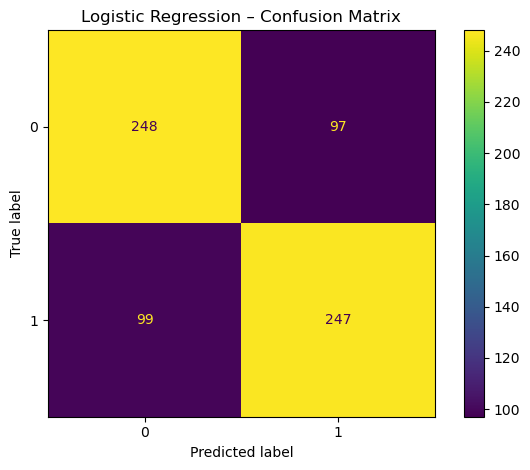

In [66]:
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)
plt.title("Logistic Regression – Confusion Matrix")
plt.grid(False)
plt.tight_layout()
plt.show()

In [67]:
print("\nClassification Report:\n", classification_report(y_test, y_pred_test))
print(f"Recall:     Train {recall_score(y_train, y_pred_train):.3f} | Test {recall_score(y_test, y_pred_test):.3f}")
print(f"Precision:  Train {precision_score(y_train, y_pred_train):.3f} | Test {precision_score(y_test, y_pred_test):.3f}")
print(f"Accuracy:   Train {accuracy_score(y_train, y_pred_train):.3f} | Test {accuracy_score(y_test, y_pred_test):.3f}")
print(f"F1 Score:   Train {f1_score(y_train, y_pred_train):.3f} | Test {f1_score(y_test, y_pred_test):.3f}")
print(f"AUC Score:  Train {roc_auc_score(y_train, y_proba_train):.3f} | Test {roc_auc_score(y_test, y_proba_test):.3f}")
print(f"False Pos.: Train {false_positive_rate(y_train, y_pred_train):.3f} | Test {false_positive_rate(y_test, y_pred_test):.3f}")


Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.72      0.72       345
           1       0.72      0.71      0.72       346

    accuracy                           0.72       691
   macro avg       0.72      0.72      0.72       691
weighted avg       0.72      0.72      0.72       691

Recall:     Train 0.707 | Test 0.714
Precision:  Train 0.716 | Test 0.718
Accuracy:   Train 0.713 | Test 0.716
F1 Score:   Train 0.711 | Test 0.716
AUC Score:  Train 0.794 | Test 0.804
False Pos.: Train 0.280 | Test 0.281


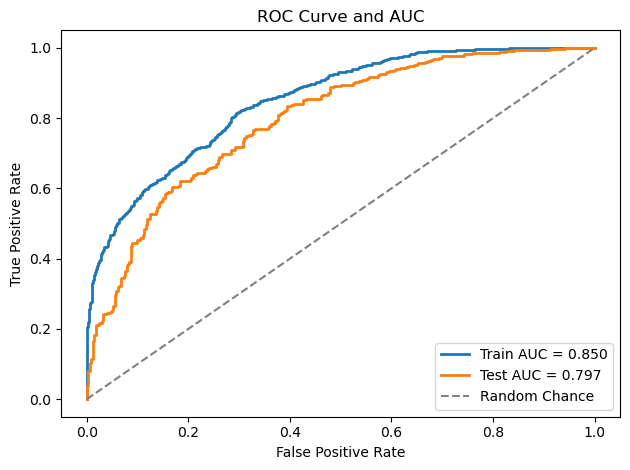

AUC (Train): 0.8505
AUC (Test):  0.7975


In [99]:
# Compute ROC curve and AUC using predicted probabilities
fpr_train, tpr_train, _ = roc_curve(y_train, y_proba_train)
fpr_test, tpr_test, _ = roc_curve(y_test, y_proba_test)

auc_train = roc_auc_score(y_train, y_proba_train)
auc_test = roc_auc_score(y_test, y_proba_test)

# Plot ROC curves
plt.figure()
plt.plot(fpr_train, tpr_train, label=f"Train AUC = {auc_train:.3f}", lw=2)
plt.plot(fpr_test, tpr_test, label=f"Test AUC = {auc_test:.3f}", lw=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Chance')

# Formatting
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve and AUC")
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

print(f"AUC (Train): {auc_train:.4f}")
print(f"AUC (Test):  {auc_test:.4f}")


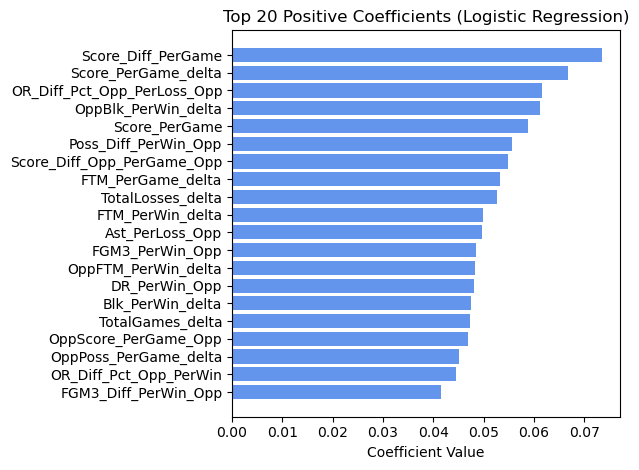

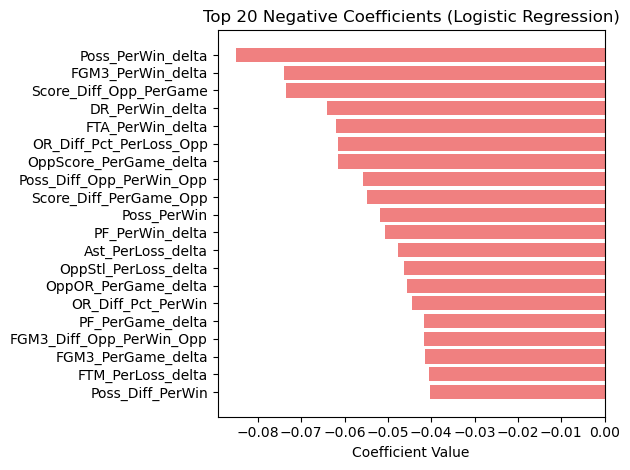

In [102]:
# Extract feature names and coefficients
features = X_train.columns
coefs = logreg_model.coef_[0] 

# Create DataFrame for coefs
coef_df = pd.DataFrame({'Feature': features, 'Coefficient': coefs})

# Top N positive and negative coefficients
n = 20
top_pos = coef_df[coef_df['Coefficient'] > 0].sort_values(by='Coefficient', ascending=False).head(n)
top_neg = coef_df[coef_df['Coefficient'] < 0].sort_values(by='Coefficient', ascending=True).head(n)

# Plot: Top Positive Coefficients
plt.figure()
plt.barh(top_pos['Feature'][::-1], top_pos['Coefficient'][::-1], color='cornflowerblue')
plt.title(f"Top {n} Positive Coefficients (Logistic Regression)")
plt.xlabel("Coefficient Value")

plt.tight_layout()
plt.show()

# Plot: Top Negative Coefficients
plt.figure()
plt.barh(top_neg['Feature'][::-1], top_neg['Coefficient'][::-1], color='lightcoral')
plt.title(f"Top {n} Negative Coefficients (Logistic Regression)")
plt.xlabel("Coefficient Value")

plt.tight_layout()
plt.show()

In [103]:
display(top_pos)
display(top_neg)

,Feature,Coefficient
53,Score_Diff_PerGame,0.073421
715,Score_PerGame_delta,0.066853
696,OR_Diff_Pct_Opp_PerLoss_Opp,0.061531
824,OppBlk_PerWin_delta,0.061292
9,Score_PerGame,0.058756
536,Poss_Diff_PerWin_Opp,0.055625
440,Score_Diff_Opp_PerGame_Opp,0.054891
722,FTM_PerGame_delta,0.053253
713,TotalLosses_delta,0.052572
804,FTM_PerWin_delta,0.049938


,Feature,Coefficient
835,Poss_PerWin_delta,-0.085045
802,FGM3_PerWin_delta,-0.073886
87,Score_Diff_Opp_PerGame,-0.073421
807,DR_PerWin_delta,-0.064073
805,FTA_PerWin_delta,-0.062027
662,OR_Diff_Pct_PerLoss_Opp,-0.061531
716,OppScore_PerGame_delta,-0.061458
570,Poss_Diff_Opp_PerWin_Opp,-0.055625
406,Score_Diff_PerGame_Opp,-0.054891
163,Poss_PerWin,-0.051722


***
### Logistic Regression Coefficient Interpretation

Below are the most influential features identified by our logistic regression model, sorted by their coefficients. Positive coefficients are associated with a higher likelihood of winning a given NCAA tournament matchup, while negative coefficients are linked to a greater chance of losing.

In the high-variance context of March Madness, small statistical edges can have outsized effects — and these features offer insight into the factors most predictive of success. From scoring margins and possession-based efficiency to opponent-adjusted deltas, the model captures not just how well a team performs, but how that performance compares to its competition. This allows us to move beyond seeding or win-loss records and quantify the matchup-specific information that often drive upsets or validate chalk picks.

These coefficients not only reflect basketball intuition (e.g., outscoring your opponent) but also highlight hidden value in tempo, rebounding margins, and opponent tendencies — critical dimensions for modeling tournament volatility through a data science lens.

#### Top Positive Coefficients (Strongest predictors of winning)

- Score-based metrics such as `Score_Diff_PerGame`, `Score_PerGame_delta`, and `Score_PerGame` emerge as the strongest positive predictors. This reaffirms that not just scoring, but by *how much* a team outpaces its competition, carries significant predictive weight.
- Opponent rebounding and rim protection features like `OR_Diff_Pct_Opp_PerLoss_Opp` and `OppBlk_PerWin_delta` show that limiting opponents’ second-chance points and minimizing shot-block disruption are subtle but meaningful contributors to win probability.
- `Poss_Diff_PerWin_Opp` and `OppPoss_PerGame_delta` show that pace of play and possession control on both sides matter.
- Features like `FTM_PerGame_delta`, `Ast_PerLoss_Opp`, and `OppFTM_PerWin_delta` highlight how foul shooting and ball movement metrics factor into performance differences between teams.
- Several `_delta` features indicate that the difference between a team and its opponent across advanced stats like FTM, Blk, and TotalGames are also important predictors.

#### Top Negative Coefficients (Predictors associated with lower likelihood of winning)

- `Poss_PerWin_delta` and `FGM3_PerWin_delta` indicate that teams who appear efficient but face opponents who do even better in these metrics tend to underperform.
- `Score_Diff_Opp_PerGame` and `OppScore_PerGame_delta` emphasize the importance of limiting opponent scoring — unsurprisingly, high opponent scoring metrics are strong negative signals.
- `DR_PerWin_delta`, `FTA_PerWin_delta`, and `PF_PerWin_delta` suggest that teams with relatively weaker rebounding, poor free throw drawing, or high foul rates are disadvantaged.
- Opponent-side differentials like `OppStl_PerLoss_delta` and `OppOR_PerGame_delta` reinforce that turnovers and rebounding against are problematic.
- Possession-based and foul metrics such as `Poss_PerWin`, `PF_PerGame_delta`, and `Poss_Diff_PerWin` further reinforce the importance of game control and discipline.

### Takeaways

- Scoring margin and possession efficiency remain among the strongest individual predictors.
- Delta features, representing stat differences between teams in a matchup, are highly predictive and validate the modeling approach of pairing team-season aggregates.
- Opponent-adjusted features are especially valuable — both in raw and differential form — reinforcing the importance of relative strength.
- The model also appears sensitive to nuanced aspects of the game like foul drawing, rebounding margins, and assist-to-turnover ratios.

These findings align with both intuitive basketball understanding and robust statistical learning principles, providing a strong foundation for model interpretation and future feature refinement.
***

### Model Evaluation Summary: Logistic Regression

Our logistic regression model demonstrates balanced and consistent performance across both training and test sets, suggesting strong generalization to unseen NCAA tournament matchups.

The overall test accuracy of ~71.6% outperforms the naive "chalk" baseline (~70.2%), confirming that the model captures signal beyond seeding and win percentage alone.

From a classification standpoint:

- Precision and recall are nearly symmetric across both classes (`Win = 1`, `Loss = 0`), indicating the model handles favorites and underdogs with similar reliability, which is sensible given the data is a perfect 50/50 class.
- F1 scores (~0.71–0.72) are consistent across train and test, suggesting the model is neither overfitting nor underfitting.
- AUC scores are particularly strong — a threshold-independent metric indicating that the model can discriminate between winners and losers with high confidence.

#### Performance Summary

| Metric          | Train Set | Test Set |
|-----------------|-----------|----------|
| Accuracy        | 0.713     | 0.716    |
| Precision       | 0.716     | 0.718    |
| Recall          | 0.707     | 0.714    |
| F1 Score        | 0.711     | 0.716    |
| AUC Score       | 0.794     | 0.804    |
| False Pos. Rate | 0.280     | 0.281    |

The AUC score (~0.80) is especially encouraging: it means that, on average, the model assigns a higher predicted probability to the actual winner roughly 80% of the time — a strong result in the context of March Madness, where many matchups are tightly contested.

---

### Key Takeaways

- The model beats a simple higher-seed baseline, establishing a data-informed benchmark for future iterations.
- AUC metrics show the model is particularly effective in distinguishing winners from losers, especially in less predictable matchups.
- Strong alignment between training and test performance suggests our feature set and model complexity are well-calibrated.

With a strong logistic regression baseline in place, we now can now turn to more complex models — beginning with XGBoost.

***
## XGBoost Model

XGBoost is a powerful ensemble learning method based on gradient-boosted decision trees. Unlike linear models such as logistic regression, XGBoost can model complex, nonlinear relationships and interactions between features.

In the context of NCAA tournament prediction, where matchups hinge on subtle differences in team strength, playing style, and statistical nuance, XGBoost offers a flexible framework to capture patterns that may not be linearly separable. We'll train and evaluate an XGBoost model using the same feature set and metrics, allowing for a direct comparison to our logistic regression model.
***

In [72]:
# Define pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])

# Define parameter grid
param_grid = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [3, 5],
    'model__learning_rate': [0.01, 0.1],
    'model__subsample': [0.8, 1.0]
}

In [73]:
# Grid Search
grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)
best_model = grid.best_estimator_

Fitting 5 folds for each of 16 candidates, totalling 80 fits


In [74]:
# Predictions
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)
y_proba_train = best_model.predict_proba(X_train)[:, 1]
y_proba_test = best_model.predict_proba(X_test)[:, 1]

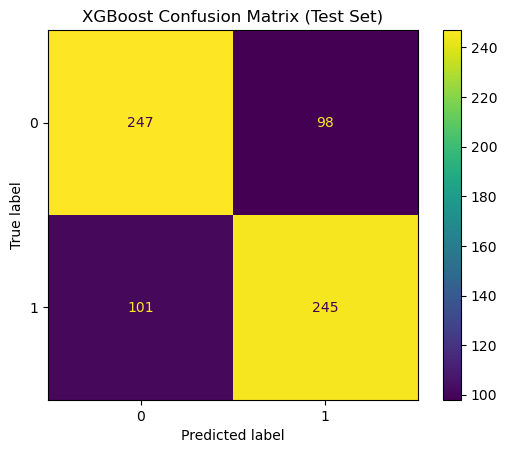

In [80]:
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)
plt.title("XGBoost Confusion Matrix (Test Set)")
plt.grid(False)
plt.show()

In [79]:
# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred_test))

# Metrics
print(f"Accuracy (Train): {accuracy_score(y_train, y_pred_train):.3f}")
print(f"Accuracy (Test):  {accuracy_score(y_test, y_pred_test):.3f}")
print(f"ROC AUC (Train):  {roc_auc_score(y_train, y_proba_train):.3f}")
print(f"ROC AUC (Test):   {roc_auc_score(y_test, y_proba_test):.3f}")

Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.72      0.71       345
           1       0.71      0.71      0.71       346

    accuracy                           0.71       691
   macro avg       0.71      0.71      0.71       691
weighted avg       0.71      0.71      0.71       691

Accuracy (Train): 0.744
Accuracy (Test):  0.712
ROC AUC (Train):  0.850
ROC AUC (Test):   0.797


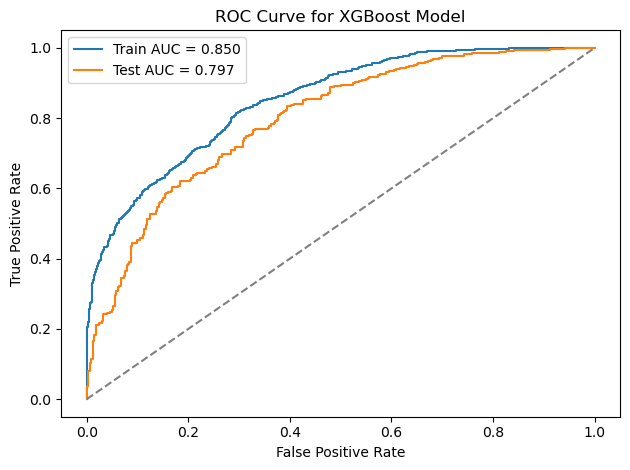

In [82]:
# ROC curve
fpr_train, tpr_train, _ = roc_curve(y_train, y_proba_train)
fpr_test, tpr_test, _ = roc_curve(y_test, y_proba_test)

plt.figure()
plt.plot(fpr_train, tpr_train, label=f"Train AUC = {roc_auc_score(y_train, y_proba_train):.3f}")
plt.plot(fpr_test, tpr_test, label=f"Test AUC = {roc_auc_score(y_test, y_proba_test):.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for XGBoost Model")

plt.legend()
plt.tight_layout()
plt.show()

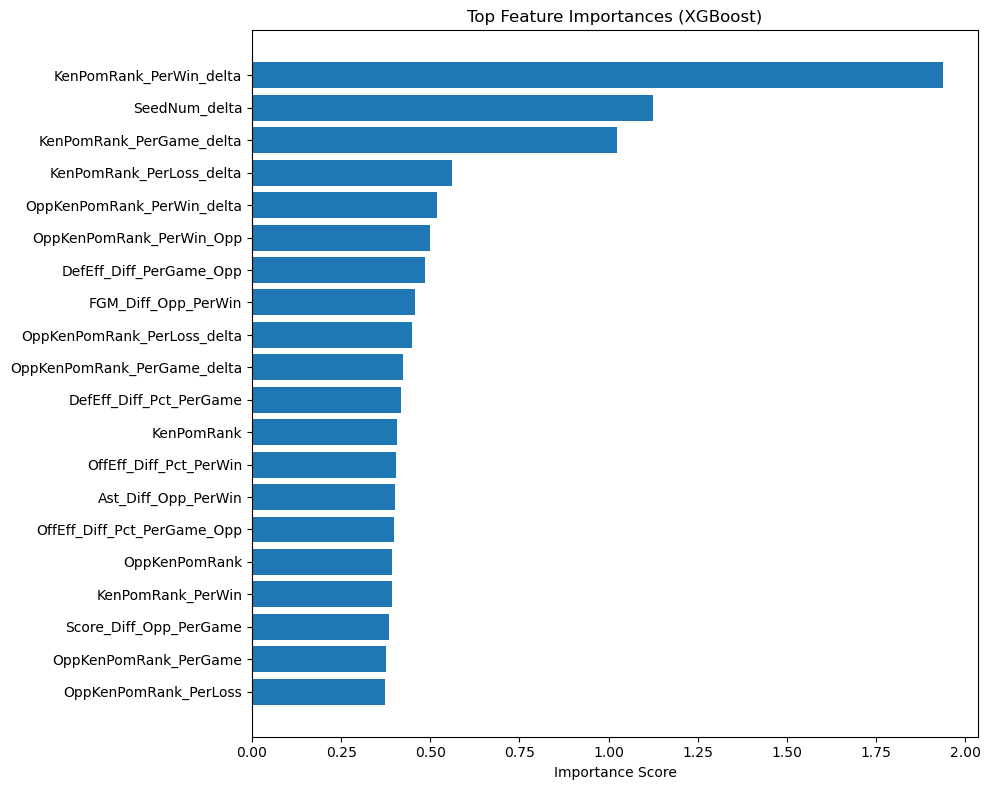

In [107]:
importances = best_model.named_steps['model'].feature_importances_ * 100
features = X_train.columns

importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False).reset_index(drop=True)


# Top N features
n = 20
top_features_df = importance_df.head(n)

plt.figure(figsize=(10, 8))
plt.barh(top_features_df['Feature'][::-1], top_features_df['Importance'][::-1])
plt.title("Top Feature Importances (XGBoost)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

In [108]:
top_features_df

,Feature,Importance
0,KenPomRank_PerWin_delta,1.938441
1,SeedNum_delta,1.123254
2,KenPomRank_PerGame_delta,1.022337
3,KenPomRank_PerLoss_delta,0.561041
4,OppKenPomRank_PerWin_delta,0.517832
5,OppKenPomRank_PerWin_Opp,0.499477
6,DefEff_Diff_PerGame_Opp,0.484750
7,FGM_Diff_Opp_PerWin,0.456311
8,OppKenPomRank_PerLoss_delta,0.448999
9,OppKenPomRank_PerGame_delta,0.424228


***
### XGBoost Feature Importances: Interpretation

The XGBoost model highlights several features with high predictive power, and many different factors relative to our logistic regression model. Many of the most important inputs are related to team quality and matchup differentials — especially those derived from advanced metrics like `KenPomRank` and possession-based efficiency.

#### Top Features

- **KenPom-based differentials dominate**: 
  - `KenPomRank_PerWin_delta`, `SeedNum_delta`, and `KenPomRank_PerGame_delta` are the most important predictors.
  - These features measure the difference in rankings between a team and its opponent across different game contexts (overall, per win/loss), emphasizing how relative team strength (rather than absolute strength) is most informative.

- **Opponent quality matters**:
  - Features like `OppKenPomRank_PerWin_delta` and `OppKenPomRank_PerGame_delta` reflect the caliber of competition a team has faced and performed against — especially in wins. 
  - This reinforces the idea that not all wins are created equal — beating strong teams carries more predictive signal.

- **Adjusted Efficiency Metrics**:
  - `DefEff_Diff_PerGame_Opp`, `DefEff_Diff_Pct_PerGame`, and `OffEff_Diff_Pct_PerWin` indicate the importance of tempo-free, possession-adjusted metrics. These capture how well a team executes on both sides of the ball relative to their opponents.

- **Assist and scoring differences**:
  - `Ast_Diff_Opp_PerWin` and `FGM_Diff_Opp_PerWin` suggest that generating and limiting assisted scoring opportunities plays a meaningful role in outcomes.
  - `Score_Diff_Opp_PerGame` again points to margin of victory — even on the opponent side — as a key differentiator.

#### Summary

The XGBoost model captures nuanced dimensions of team performance that go beyond seedings or win-loss records. By focusing on **delta features** (team vs. opponent), **advanced ratings** (KenPom), and **tempo-aware stats**, the model effectively learns the statistical profile of teams likely to outperform expectations in the high-variance setting of the NCAA tournament.
***